# 2a: Find the benchmark thrombolysis rate for each stroke team

## Plain English summary
We want to compare the decisions made by each stroke team with the decisions that we expect the benchmark teams to make. 

To do this, we use the prediction model to send all of one hospital's patients to all of the benchmark hospitals instead, changing no patient details except the stroke team ID. We take the 25 separate thrombolysis decisions from the 25 benchmark hospitals. If at least half of the benchmark hospitals would have thrombolysed the patient, the majority benchmark decision is to thrombolyse. Otherwise, the decision is to not thrombolyse. The benchmark thrombolysis rate is the percentage of patients for whom the majority benchmark decision is to thrombolyse.

<img src="images/flowchart_benchmark_scenario_rates.png" alt="Flowchart of the calculation of benchmark thrombolysis rate. The data is divided into subsets that pass a series of tests. The patients in the subsets are assigned each of the benchmark hospital names in turn and the prediction model decides whether those teams would have thrombolysed the patients. We calculate the real and benchmark thrombolysis rates for each stroke team." width="75%"/>

The pathway tests are shown in the following flowchart:

<img src="images/flowchart_pathway_tests.png" alt="Flowchart of the pathway tests." width="50%"/>

## Notebook setup:

In [27]:
import pandas as pd
import numpy as np
import pickle
from dataclasses import dataclass
import yaml

import matplotlib.pyplot as plt

import stroke_utilities.scenario as scenario
import stroke_utilities.process_data as process_data

## Set up paths and filenames

In [28]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './stroke_utilities/data/'
    output_folder = './stroke_utilities/output/'
    model_folder = './stroke_utilities/models'

paths = Paths()

## Import existing utilities

The prediction model and benchmark ranking list were created in the notebook `01_create_predictor_shap_and_benchmark_rankings`.

Import prediction model:

In [29]:
with open(f'{paths.model_folder}/model.p', 'rb') as fp:
    model = pickle.load(fp)

Import benchmark ranking list:

In [30]:
df_benchmark_codes = pd.read_csv(
    f'{paths.output_folder}/benchmark_codes.csv',
    index_col='stroke_team_id'
    )

df_benchmark_codes

,shap_mean,Rank
stroke_team_id,,
102,1.341623,1
72,1.111925,2
8,0.997945,3
71,0.949360,4
37,0.905034,5
...,...,...
117,-0.688748,115
58,-0.820926,116
65,-0.832516,117


Keep only the top 25 teams as the benchmark team ID list.

In [31]:
benchmark_team_id_list = df_benchmark_codes.index.values[:25]

benchmark_team_id_list

array([102,  72,   8,  71,  37,  57, 115,  48,  21,  80, 104,  83, 118,
        98,  64,  19,   2, 103,  97,  63,  95,  13,  31, 101,  34])

Import the full dataset covering all patients attending all stroke teams:

In [32]:
filename = paths.data_read_path + 'clean_samuel_ssnap_extract_v2.csv'
big_data = pd.read_csv(filename)

In [33]:
big_data.columns

Index(['id', 'stroke_team', 'age', 'male', 'infarction',
       'onset_to_arrival_time', 'onset_known', 'precise_onset_known',
       'onset_during_sleep', 'arrive_by_ambulance',
       'call_to_ambulance_arrival_time', 'ambulance_on_scene_time',
       'ambulance_travel_to_hospital_time', 'ambulance_wait_time_at_hospital',
       'month', 'year', 'weekday', 'arrival_time_3_hour_period',
       'arrival_to_scan_time', 'thrombolysis', 'scan_to_thrombolysis_time',
       'thrombectomy', 'arrival_to_thrombectomy_time',
       'congestive_heart_failure', 'hypertension', 'atrial_fibrillation',
       'diabetes', 'prior_stroke_tia', 'afib_antiplatelet',
       'afib_anticoagulant', 'afib_vit_k_anticoagulant',
       'afib_doac_anticoagulant', 'afib_heparin_anticoagulant',
       'new_afib_diagnosis', 'prior_disability', 'stroke_severity',
       'nihss_complete', 'nihss_arrival_loc', 'nihss_arrival_loc_questions',
       'nihss_arrival_loc_commands', 'nihss_arrival_best_gaze',
       'nihss_

In [34]:
big_data = big_data[np.isnan(big_data['stroke_team_id']) == False]

big_data['stroke_team_id'] = big_data['stroke_team_id'].astype(int)

Restrict to 2019 and 2020 only:

In [35]:
big_data = process_data.restrict_data_to_range(big_data, 2019, 2020, 'year')

/home/anna/stroke-modelling/stroke-utilities/stroke_utilities/process_data.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(column, inplace=True, axis=1)


Extract the stroke team names from this big data set:

In [36]:
all_team_names = sorted(
    list(
        set(
            big_data['stroke_team_id']
                )))

In [37]:
all_team_names

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119]

In [38]:
with open('./stroke_utilities/fixed_params.yml') as f:
    fixed_params = yaml.safe_load(f)

In [39]:
fixed_params

{'allowed_onset_to_scan_time': 240,
 'allowed_onset_to_needle_time_mins': 270,
 'allowed_overrun_for_slow_scan_to_needle_mins': 15,
 'allowed_onset_to_puncture_time_mins': 480,
 'allowed_overrun_for_slow_scan_to_puncture_mins': 15,
 'minutes_left': 15.0,
 'limit_ivt_mins': 240,
 'limit_mt_mins': 360}

In [40]:
# Set up allowed time and over-run for thrombolysis...
allowed_onset_to_needle_time_mins = fixed_params['allowed_onset_to_needle_time_mins']
allowed_overrun_for_slow_scan_to_needle_mins = fixed_params['allowed_overrun_for_slow_scan_to_needle_mins']
# ... and for thrombectomy
allowed_onset_to_puncture_time_mins = fixed_params['allowed_onset_to_puncture_time_mins']
allowed_overrun_for_slow_scan_to_puncture_mins = fixed_params['allowed_overrun_for_slow_scan_to_puncture_mins']
minutes_left = fixed_params['minutes_left']
# Limit for comparing conditions (e.g. is onset to arrival within
# 4hrs?). Separate limits for IVT and MT:
limit_ivt_mins = fixed_params['limit_ivt_mins']
limit_mt_mins = fixed_params['limit_mt_mins']

Combine existing time data to create some new measures:

In [41]:
big_data['arrival_to_thrombolysis_time'] = (
    big_data['arrival_to_scan_time'] + 
    big_data['scan_to_thrombolysis_time']
    )

# Time left after scan for thrombolysis...
big_data['time_left_for_ivt_after_scan_mins'] = np.maximum((
    allowed_onset_to_needle_time_mins -
    (big_data['onset_to_arrival_time'] + 
      big_data['arrival_to_scan_time'])
    ), -0.0)
# ... and thrombectomy:
big_data['time_left_for_mt_after_scan_mins'] = np.maximum((
    allowed_onset_to_puncture_time_mins -
    (big_data['onset_to_arrival_time'] + 
      big_data['arrival_to_scan_time'])
    ), -0.0)

## Example: types of patients attending Team 1

As an example of selecting subsets of patient data, we will look at the breakdown of patients attending Team 1.

Take all of the patients who attended this particular stroke team:

In [42]:
group_df = big_data[big_data['stroke_team_id'] == 1]

Label whether each patient has an LVO, nLVO, or "other" stroke type. All non-infarction patients are designated "other". All patients with infarctions and a stroke severity of at least 11 are designated LVO, and everyone else is nLVO.

In [43]:
stroke_type_mask_dict = {
    'lvo': ((group_df['infarction']==1) & 
            (group_df['stroke_severity']>=11)),
    'nlvo': ((group_df['infarction']==1) & 
             (group_df['stroke_severity']<11)),
    'other': (group_df['infarction']!=1),  # excludes no type given
    'mixed': [True] * len(group_df)
}

Next we pick out only the patients who pass all of the following questions:
1. Is onset time known?
2. Is onset to arrival within the time limit?
3. Is arrival to scan wtihin the time limit?
4. Is onset to scan within the time limit?
5. Is there enough time left for thrombolysis?
6. Did the patient receive thrombolysis?

The following function sets up a bar chart of the proportions of patients who pass each question in turn.

In [44]:
def plot_bars_all_masks(
        ax, n_lists, colour_true, colour_false, y_labels, annotate=True
        ):
    """Plot bar charts of proportions of patients passing each mask."""
    labels = ['Yes', 'No', 'Rejected']
    colours = [colour_true, colour_false, colour_false]
    
    for b, bars in enumerate(n_lists):
        cumsum = np.append(0.0, np.cumsum(bars))
        for i, bar in enumerate(bars):
            ax.barh(-b, bar, left=cumsum[i], height=0.8,
                    color=colours[i], edgecolor='k')
            mid = np.mean([cumsum[i], cumsum[i+1]])
            if annotate is True:
                ax.annotate(labels[i] + '\n' + str(bar), 
                            xy=(mid, -b), ha='center', va='center')

    ax.set_xticks([])
    ax.set_yticks(np.arange(0.0, -len(n_lists), -1.0))
    ax.set_yticklabels(y_labels)
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)
    # Prevent the bar outline being cut off on the right:
    ax.set_xlim(0.0, ax.get_xlim()[1]*1.01)
    return ax

The following cell creates masks of the patients that pass each question in turn, counts how many patients there are at each point, and creates the bar chart.

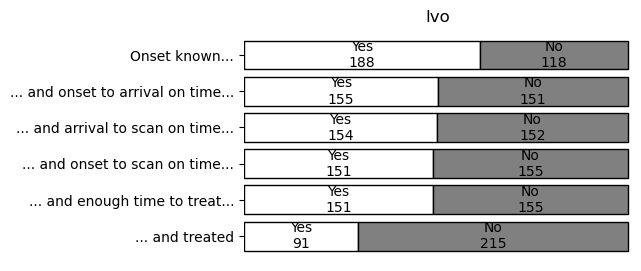

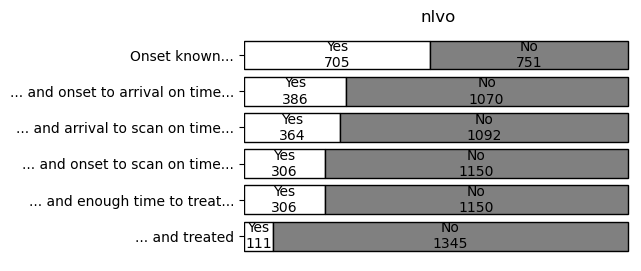

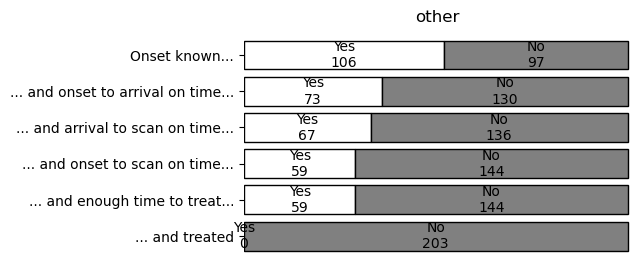

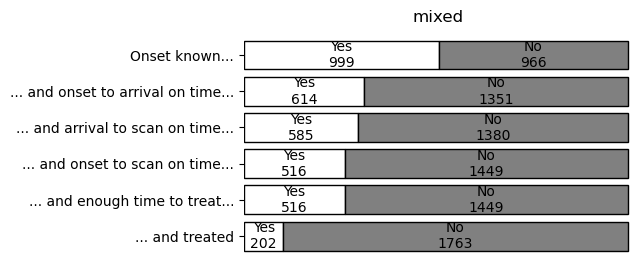

In [45]:
axis_labels = [
    'Onset known...',
    '... and onset to arrival on time...',
    '... and arrival to scan on time...',
    '... and onset to scan on time...',
    '... and enough time to treat...',
    '... and treated'
    ]

colour_true = 'w'
colour_false = 'grey'

for stroke_type in ['lvo', 'nlvo', 'other', 'mixed']:
    # Pick out data for just this stroke type:
    group_stroke_type_df = group_df[stroke_type_mask_dict[stroke_type]].copy()

    # Create masks of various pathway conditions:
    masks_dict_ivt = scenario.create_masks(
            group_stroke_type_df,
            group_stroke_type_df['time_left_for_ivt_after_scan_mins'],
            group_stroke_type_df['arrival_to_thrombolysis_time'],
            limit_ivt_mins,
            minutes_left
            )
    # Convert the dictionary to a list to shorten the "n_lists" bit:
    masks_lists = [masks_dict_ivt[key] for key in masks_dict_ivt.keys()]

    # How many (n) patients answer yes and no to each mask?
    n_lists = []
    for mask in masks_lists:
        n_yes = len(np.where(mask == 1)[0])
        n_no = len(np.where(mask != 1)[0])
        n_lists.append([n_yes, n_no, np.NaN])

    # Draw the plot:
    fig, ax_masks = plt.subplots(figsize=(5, 3))
    ax_masks = plot_bars_all_masks(
        ax_masks, n_lists, colour_true, colour_false, axis_labels, annotate=True)
    ax_masks.set_title(stroke_type)
    plt.show()

The number written in each bar is the number of patients in that category after answering that mask.

We want to take all of the patients who pass the first five masks (onset known and ... and enough time to treat) and see whether the benchmark stroke teams would have chosen to thrombolyse them.

## Benchmark scenario

For each stroke team, we will find the subset of patients for each stroke type that pass all of the masks above, and then compare the actual thrombolysis rate of those patients with the rate had they taken the benchmark majority decision.

The model will use these features:

In [46]:
# Put data into the format for model
features_to_model = [
    # 'stroke_team_id',
    'stroke_severity',
    'prior_disability',
    'age',
    'infarction',
    'onset_to_arrival_time',
    'precise_onset_known',
    'onset_during_sleep',
    'arrival_to_scan_time',
    'afib_anticoagulant',
    # 'year',    
    'thrombolysis'
] + [f'team_{t}' for t in all_team_names]

Split "stroke_team_id" column into a separate column for each team:

In [47]:
big_data['stroke_team_id']

33436     19
119139    73
119238    91
119239    73
119299    43
          ..
358902    38
358916    38
358937    38
358941    38
358957    38
Name: stroke_team_id, Length: 119263, dtype: int64

In [48]:
big_data = process_data.one_hot_encode_column(big_data, 'stroke_team_id', prefix='team')

In [49]:
big_data.columns

Index(['id', 'stroke_team', 'age', 'male', 'infarction',
       'onset_to_arrival_time', 'onset_known', 'precise_onset_known',
       'onset_during_sleep', 'arrive_by_ambulance',
       ...
       'team_110', 'team_111', 'team_112', 'team_113', 'team_114', 'team_115',
       'team_116', 'team_117', 'team_118', 'team_119'],
      dtype='object', length=191)

The following function does the following:
+ Pull out the subset of data for one team, for one stroke type, and who pass the first five masks.
+ Find the base thrombolysis rate.
+ Find the benchmark thrombolysis rate - send each patient to all of the benchmark teams and take the benchmark majority decision on whether they receive treatment.

The thrombolysis rates are recorded for both the subset ("rate of mask5") and the set of all patients who attended that team with that stroke type.

In [50]:
all_teams_benchmark_thrombolysis_rates = scenario.predict_thrombolysis_rate_in_benchmark_scenario(
    big_data, 
    model,
    benchmark_team_id_list,
    features_to_model,
    limit_ivt_mins,
    minutes_left,
    all_team_names,
    team_id_column='stroke_team_id', 
    prediction_column='thrombolysis',
    split_by_stroke_type=True
    )

## Results

In [51]:
all_teams_benchmark_thrombolysis_rates

,Stroke type,Base,Benchmark,Base rate of mask5,Benchmark rate of mask5
stroke_team_id,,,,,
1,nlvo,0.074669,0.108165,0.356667,0.516667
1,lvo,0.297386,0.375817,0.602649,0.761589
1,other,0.000000,0.000000,0.000000,0.000000
1,mixed,0.102799,0.139949,0.391473,0.532946
2,nlvo,0.111950,0.122013,0.408257,0.444954
...,...,...,...,...,...
118,mixed,0.145749,0.114372,0.393443,0.308743
119,nlvo,0.070743,0.098321,0.266968,0.371041
119,lvo,0.211340,0.262887,0.422680,0.525773


Save to file:

In [52]:
all_teams_benchmark_thrombolysis_rates.to_csv(
    f'{paths.output_folder}/benchmark_rates_thrombolysis.csv',
    index=True
    )

## Compare the "base" and "benchmark" scenarios

Make some quick plots to compare the thrombolysis rates in the "base" and "benchmark" scenarios.

In the plots, benchmark teams are drawn with a red marker and non-benchmark teams are blue. If the marker lies above the diagonal black line, then the benchmark thrombolysis rate is higher than the base rate. Otherwise, the benchmark rate is lower than the base rate.


Worsened teams:  [8, 13, 19, 20, 21, 24, 37, 48, 57, 61, 64, 72, 79, 80, 83, 97, 98, 102, 103, 104, 109, 115, 116, 118]
24 out of 119 teams got worse.
Benchmark teams:  [2, 8, 13, 19, 21, 31, 34, 37, 48, 57, 63, 64, 71, 72, 80, 83, 95, 97, 98, 101, 102, 103, 104, 115, 118]


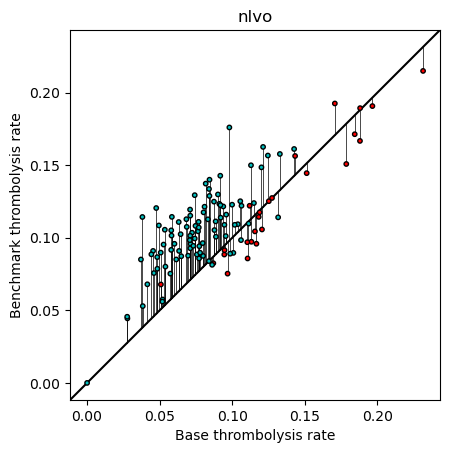

Worsened teams:  [37, 42, 48, 71, 79, 83, 94, 103, 104, 107, 115, 116, 118]
13 out of 119 teams got worse.
Benchmark teams:  [2, 8, 13, 19, 21, 31, 34, 37, 48, 57, 63, 64, 71, 72, 80, 83, 95, 97, 98, 101, 102, 103, 104, 115, 118]


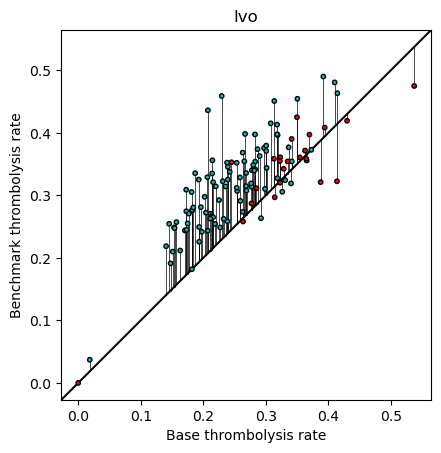

Worsened teams:  []
0 out of 119 teams got worse.
Benchmark teams:  [2, 8, 13, 19, 21, 31, 34, 37, 48, 57, 63, 64, 71, 72, 80, 83, 95, 97, 98, 101, 102, 103, 104, 115, 118]


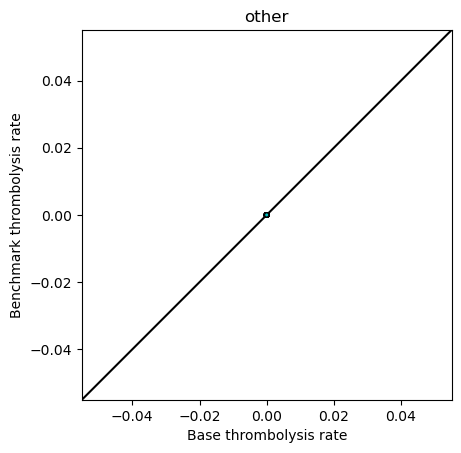

Worsened teams:  [8, 13, 37, 48, 57, 71, 72, 79, 80, 83, 98, 102, 103, 104, 109, 115, 116, 118]
18 out of 119 teams got worse.
Benchmark teams:  [2, 8, 13, 19, 21, 31, 34, 37, 48, 57, 63, 64, 71, 72, 80, 83, 95, 97, 98, 101, 102, 103, 104, 115, 118]


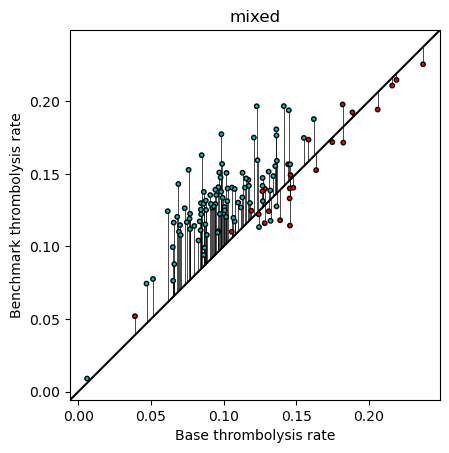

In [53]:
for stroke_type in ['nlvo', 'lvo', 'other', 'mixed']:
    # Pick out just the data for this stroke type:
    arr_here = all_teams_benchmark_thrombolysis_rates[
        all_teams_benchmark_thrombolysis_rates['Stroke type'] == stroke_type]

    # Which teams got worse?
    w = sorted(np.array(arr_here.index[arr_here['Base'] >
                     arr_here['Benchmark']].values, dtype=int))
    print('Worsened teams: ', w)
    print(f'{len(w)} out of {len(arr_here)} teams got worse.')
    print('Benchmark teams: ', sorted(benchmark_team_id_list))
    
    # Define colours for the markers. Initially, everyone is blue:
    colour_list = np.array(['c' for team in arr_here.index])
    for team_id in benchmark_team_id_list:
        # If the team is a benchmark, change the colour to red:
        inds = np.where(arr_here.index == str(team_id))[0]
        colour_list[inds] = 'r'
    
    fig, ax = plt.subplots()
    # Plot the thrombolysis rate scatter markers:
    ax.scatter(arr_here['Base'], arr_here['Benchmark'],
               c=colour_list, s=10, edgecolor='k')
    # Draw diagonal line where y=x.
    ax.plot([arr_here['Base'], arr_here['Base']],
            [arr_here['Base'], arr_here['Benchmark']],
            color='k', zorder=0, linewidth=0.5)
    # Plot setup:
    ax.set_aspect('equal')
    lim_min = np.min([list(ax.get_xlim()), list(ax.get_ylim())])
    lim_max = np.max([list(ax.get_xlim()), list(ax.get_ylim())])
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    # Diagonal line:
    ax.plot([lim_min, lim_max], [lim_min, lim_max], color='k', zorder=0)
    
    ax.set_xlabel('Base thrombolysis rate')
    ax.set_ylabel('Benchmark thrombolysis rate')
    ax.set_title(stroke_type)
    plt.show()

We expect to see that most teams have improved with the benchmark scenario. The teams that have a lower thrombolysis rate in the "benchmark" scenario are usually benchmark teams themselves.